In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import math
from collections import namedtuple, deque
from itertools import count
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from air_hock_env import AirHockeyEnv

In [2]:
env = AirHockeyEnv()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
obs, info = env.reset()

print(obs, obs.shape)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]] (800, 400, 3)


In [4]:
obs_list = []

for i in range(100):
    obs, reward, done, truncated, info = env.step(action = np.random.randint(0,9))
    # save obs to list
    obs_list.append(obs)
    # print(obs, reward, done)
    if done:
        break

In [5]:
for obs in obs_list:
    assert obs.shape == (800, 400, 3)

In [6]:
# make a list of random tensors
obs_list2 = [torch.tensor(obs).permute(2, 0, 1).unsqueeze(0).float() for obs in obs_list]

In [7]:
for obs in obs_list2:
    assert obs.shape == (1, 3, 800, 400)

In [8]:
torch.cat(obs_list2)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

AssertionError: torch.Size([1, 1, 800, 400])

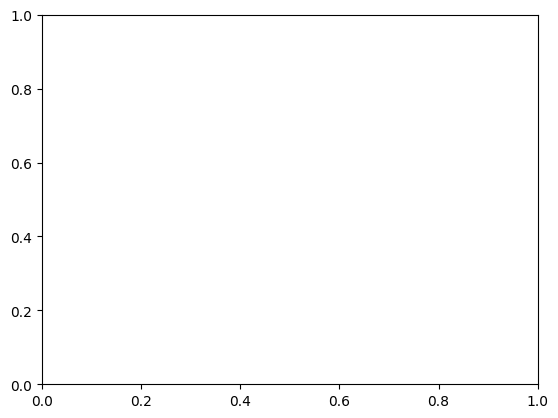

: 

In [10]:
# hyperparameters
BATCH_SIZE = 64 
GAMMA = 0.99  # Discount factor for future rewards
EPS_START = 0.95  # Initial epsilon value for epsilon-greedy action selection
EPS_END = 0.05  # Final epsilon value for epsilon-greedy action selection
EPS_DECAY = 200  # Rate at which epsilon decreases
LR = 1e-4  # Learning rate for the optimizer
TARGET_UPDATE = 10  # How often to update the target network
MEMORY_CAPACITY = 10000  # Capacity of the replay memory
NUM_EPISODES = 50  # Number of episodes to train

# Replay memory to store transitions
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# class designed to hold a collection of previous experiences or transitions the agent 
# has observed. This allows the reinforcement learning agent to sample from past experiences 
# and learn from them, avoiding the need to learn solely from immediate real-time interactions.
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)  # Initialize a double-ended queue with a fixed maximum length

    def push(self, *args):
        self.memory.append(Transition(*args))  # Append a new transition to the memory, packing any arguments into the Transition tuple

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)  # Randomly sample a batch of transitions from the memory

    def __len__(self):
        return len(self.memory)  # Return the current size of the memory

# Neural network model
class DQN(nn.Module):
    def __init__(self, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2) # 3 input channels - stack of 3 grayscale frames
        self.bn1 = nn.BatchNorm2d(16) # batch normalization
        self.pool1 = nn.AvgPool2d(2)  # avg pooling
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.AvgPool2d(2)  # avg pooling
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool3 = nn.AvgPool2d(2)  # avg pooling
        
        # Calculate the size of the output from the final pooling layer
        self._to_linear = None
        self._get_conv_output([1, 3, 800, 400])

        self.head = nn.Linear(self._to_linear, outputs) # linear layer to output the Q-values for each action

    # automatically determine the number of features that need to be passed to the final linear layer
    def _get_conv_output(self, shape):
        input = torch.rand(shape)
        output = self.pool1(self.bn1(self.conv1(input)))
        output = self.pool2(self.bn2(self.conv2(output)))
        output = self.pool3(self.bn3(self.conv3(output)))
        self._to_linear = int(torch.numel(output) / output.shape[0])

    # forward pass through the network
    def forward(self, x):
        x = F.relu(self.pool1(self.bn1(self.conv1(x))))
        x = F.relu(self.pool2(self.bn2(self.conv2(x))))
        x = F.relu(self.pool3(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        return self.head(x)

# Assuming the outputs variable is defined (number of actions in your environment)
# outputs = env.action_space.n (make sure to define this before initializing DQN if it's not already defined)
# model = DQN(outputs)

# Instantiate the policy and target networks from the DQN class defined earlier
policy_net = DQN(env.action_space.n).to(device)  # Initialize policy network for action value estimation
target_net = DQN(env.action_space.n).to(device)  # Initialize target network to stabilize learning
target_net.load_state_dict(policy_net.state_dict())  # Copy weights from policy_net to target_net
target_net.eval()  # Set target_net to evaluation mode, which disables training specific layers like dropout

# Set up the optimizer for the policy network
optimizer = optim.Adam(policy_net.parameters(), lr=LR)  # Use the Adam optimizer for policy_net with a specified learning rate

# Initialize the replay memory
memory = ReplayMemory(MEMORY_CAPACITY)  # Create a ReplayMemory object with a defined capacity

# Define a function to select an action based on the current state and the number of steps done
def select_action(state, steps_done):
    sample = random.random()  # Generate a random sample for epsilon-greedy strategy
    # Calculate epsilon threshold for epsilon-greedy action selection
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():  # Temporarily set all the requires_grad flag to false
            # Select action with the highest predicted Q-value from policy_net
            return policy_net(state).max(1)[1].view(1, 1)  # Get the action with the highest Q-value
    else:
        # Return a random action within the action space of the environment
        return torch.tensor([[random.randrange(env.action_space.n)]], device=device, dtype=torch.long)

# function iteratively improves policy network by minimizing the difference between predicted Q-values 
# and the target Q-values derived from the Bellman equation, thus refining the agent's policy to maximize future rewards
def optimize_model():
    # Check if the memory has enough samples to form a complete batch
    if len(memory) < BATCH_SIZE:
        print('Not enough samples in memory for a complete batch')
        return # If not enough samples, exit the function

    # sample a batch of transitions from the replay memory
    transitions = memory.sample(BATCH_SIZE)
    # Zip the batch and rearrange it into a Transition of batches instead of a batch of Transitions
    batch = Transition(*zip(*transitions))

    # Create a mask to identify transitions with a non-final next state
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    # Collect non-final next states into a tensor
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    for s in batch.state:
        assert s.shape == (1, 3, 800, 400), str(s.shape)
    # Concatenate all states, actions, and rewards into separate batches
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q values for each state-action pair in the batch from the policy network
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Initialize a tensor of zeros to hold the next state values
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # Update the values for non-final states from the target network (detach to avoid training the target net)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values for each state-action pair using the Bellman equation
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute the loss between the current Q values and the target Q values
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Perform gradient descent updates
    optimizer.zero_grad()  # Reset gradients to zero before backpropagation
    loss.backward()  # Compute the gradient of the loss with respect to all trainable parameters
    optimizer.step()  # Apply the gradients to update the weights


# Set up for live updating of a plot during the training process.
plt.ion()  # Enable interactive mode, which allows dynamic updates to the plot.
fig, ax = plt.subplots()  # Create a new figure and axes for plotting.
episode_rewards = []  # Initialize a list to store the cumulative rewards of each episode.

# Function definition to plot the rewards after each episode.
def plot_rewards():
    ax.clear()  # Clear the current axes.
    ax.plot(episode_rewards)  # Plot the cumulative rewards per episode.
    ax.set_title('Episode vs Rewards')  # Set the title of the plot.
    ax.set_xlabel('Episode')  # Label the x-axis as 'Episode'.
    ax.set_ylabel('Cumulative Reward')  # Label the y-axis as 'Cumulative Reward'.
    plt.draw()  # Redraw the current figure.

# Start of the training loop.
steps_done = 0  # Initialize the step counter.
for i_episode in range(NUM_EPISODES):  # Loop over each episode.
    env.reset()  # Reset the environment at the start of each episode.
    state = env.get_state()  # Get the initial state from the environment.
    # Process the state to match the expected input format of the neural network and send to the computing device.
    state = torch.from_numpy(state).permute(2, 0, 1).unsqueeze(0).float().to(device)
    total_reward = 0  # Initialize the total reward for the episode.

    for t in count():  # Infinite loop for each time step in the episode.
        action = select_action(state, steps_done)  # Select an action using the defined policy.
        # Take the selected action and observe the next state and reward, along with done flag (episode end).
        next_state, reward, done, truncated, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)  # Convert the reward to a tensor.
        total_reward += reward.item()  # Accumulate the total reward.

        # Prepare the next_state for the network or set it to None if the episode is done.
        if not done:
            next_state = torch.from_numpy(next_state).permute(2, 0, 1).unsqueeze(0).float().to(device)
        else:
            next_state = None

        assert state.shape == (1, 3, 800, 400), str(state.shape)
        memory.push(state, action, next_state, reward)  # Save the experience in the replay memory.
        state = next_state  # Update the state for the next iteration.

        optimize_model()  # Optimize the model using the collected experience.
        if done:  # If the episode has ended.
            episode_rewards.append(total_reward)  # Record the cumulative reward for the episode.
            plot_rewards()  # Update the plot with the new rewards data.
            break  # Exit the loop for the current episode.

    # Update the target network with the policy network's weights every TARGET_UPDATE episodes.
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

# Training is complete.
print('Complete')
plt.ioff()  # Disable interactive mode now that training is done.
plt.show()  # Show the plot with all the episode rewards.


In [ ]:
# Neural network model
class DQN(nn.Module):
    def __init__(self, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2) # 3 input channels - stack of 3 grayscale frames
        self.bn1 = nn.BatchNorm2d(16) # batch normalization
        self.pool1 = nn.AvgPool2d(2)  # avg pooling
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.AvgPool2d(2)  # avg pooling
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool3 = nn.AvgPool2d(2)  # avg pooling
        
        # Calculate the size of the output from the final pooling layer
        self._to_linear = None
        self._get_conv_output([1, 3, 800, 400])

        self.head = nn.Linear(self._to_linear, outputs) # linear layer to output the Q-values for each action

    # automatically determine the number of features that need to be passed to the final linear layer
    def _get_conv_output(self, shape):
        input = torch.rand(shape)
        output = self.pool1(self.bn1(self.conv1(input)))
        output = self.pool2(self.bn2(self.conv2(output)))
        output = self.pool3(self.bn3(self.conv3(output)))
        self._to_linear = int(torch.numel(output) / output.shape[0])

    # forward pass through the network
    def forward(self, x):
        x = F.relu(self.pool1(self.bn1(self.conv1(x))))
        x = F.relu(self.pool2(self.bn2(self.conv2(x))))
        x = F.relu(self.pool3(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        return self.head(x)

In [ ]:
DQN